In [1]:
import numpy as np
import random
import pandas as pd
import collections

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from keras.datasets import mnist

from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance

/home/hmenn/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# taken from hw1
def calcManhattanDistance (point1, point2):
    """
        \brief Calculate Manhattan Distance between two point
        \return Manhattan Distance
    """
    dist = 0
    for p1, p2 in zip(point1,point2):
        dist += abs(p1-p2)
    return dist

def calcConfusionMatrixAcc(matrix):
    """
        Calculate TP+TN/Total rate in ad confusion matrix
    """
    arr = np.asarray(matrix)
    return float(sum(np.diagonal(arr)))/float(sum(sum(matrix)))

Load MNIST dataset from keras and prepare data

Each data/line has 2D 28 * 28 matrix. I changed shape of data and each line has single array which has 28 * 28 = 784 value.  

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]* x_test.shape[2])

x_data = np.concatenate((x_train, x_test))
y_data = np.concatenate((y_train, y_test))
print('Data X Shape:',x_data.shape)
print('Data Y Shape:',y_data.shape)

Data X Shape: (70000, 784)
Data Y Shape: (70000,)


### PART1 USE PCA AND REDUCE FEATURES

Old features: (70000, 784)
Feature after PCA: (70000, 2)


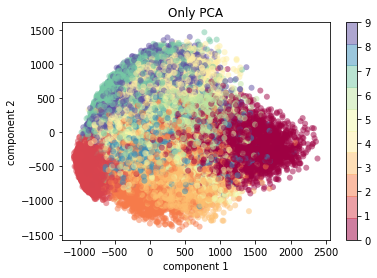

In [4]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(x_data)
print('Old features:',x_data.shape)
print('Feature after PCA:',projected.shape)

plt.scatter(projected[:, 0],projected[:, 1], #[0 for i in range(len(projected))]
            c=y_data, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.title("Only PCA")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### PART2 - Apply Kmeans on PCA data

- This function clusters data with nltk kmeans algorithm and uses kfold cross validation. For each cross results, assinges each cluster value to a label. Then counts labels and finds accuracy.
- Kmeans works for k=10

Train Error: Accuracy score of kfold train vales.
Test Error: Accuracy score of kfold test values.

In [5]:
def part2(distance_method=euclidean_distance, data_x=projected[:1000], data_y=y_data[:1000]):
    
    k = 10

    print('Data Shape:',data_x.shape,'\n')

    kf = KFold(n_splits=5)
    kFoldIndex = 1
    
    allTrainY = []
    allTrainGuess = []
    allTestY = []
    allTestGuess = []
    
    for trainIndex, testIndex in kf.split(data_x):
        print(' #########  KFold Step:', kFoldIndex,'  #########')

        kTrainX, kTestX = data_x[trainIndex], data_x[testIndex]
        kTrainY, kTestY = data_y[trainIndex], data_y[testIndex]

        clusterer = KMeansClusterer(k, distance_method, repeats=10)
        clusters = clusterer.cluster(kTrainX, True)

        table = np.zeros((10,10))

        for l,c in zip(kTrainY, clusters):
            table[l][c] = table[l][c] + 1

        df = pd.DataFrame(data=table, columns = ['C'+str(i) for i in range(k)])
        print('Table:\n',df,'\n')

        flattenTable = table.flatten()
        flattenTable[::-1].sort()

        orders = []
        for d in flattenTable:
            ind = np.where(table==d)
            for j in zip(*ind):
                orders.append(j)

        # label clusters according to explanation which exist in hw pdf
        labelsRow = {}
        labelsCol = {}
        i = 0
        while True:
            row = orders[i][0]
            col = orders[i][1]

            if (not row in labelsRow) and (not col in labelsCol):
                labelsRow[row] = (row,col, table[row][col])
                labelsCol[col] = (row,col, table[row][col])

            if len(labelsRow) == k:
                break

            i = i + 1

        clusterLabels = {}
        for i in range(k):
            clusterLabels[labelsRow[i][1]] = labelsRow[i][0]
            print('Cluster:',labelsRow[i][1],' assigned Label:',labelsRow[i][0], ' Value:', labelsRow[i][2])
        print('\n')

        allTrainY.extend(kTrainY)
        for c in clusters:
            allTrainGuess.append(clusterLabels[c])

        allTestY.extend(kTestY)
        for t in kTestX:
            allTestGuess.append(clusterLabels[clusterer.classify(t)])

        kFoldIndex = kFoldIndex + 1 
    return    allTrainY, allTrainGuess, allTestY, allTestGuess

#### NOTE: My computer is slow, so I just used 1000 data from dataset.

In [6]:
%%time
allTrainY1, allTrainGuess1, allTestY1, allTestGuess1 = part2(distance_method=euclidean_distance, data_x=projected[:1000], data_y=y_data[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
0   0.0   0.0   0.0   0.0   8.0   0.0  24.0   0.0  44.0   0.0
1  72.0  17.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0
2   5.0   4.0  11.0   9.0  19.0   4.0  26.0   1.0   0.0   0.0
3   0.0   6.0  13.0  33.0  14.0   4.0   0.0   0.0   2.0   0.0
4   0.0   4.0   0.0   0.0   3.0  28.0   0.0  28.0   0.0  21.0
5   0.0  18.0   7.0  15.0  20.0   3.0  12.0   1.0   2.0   1.0
6   1.0   8.0   3.0   0.0  26.0   7.0  18.0   1.0   0.0  11.0
7   2.0  10.0   0.0   0.0   1.0  42.0   0.0  32.0   0.0   9.0
8   1.0  11.0  30.0   7.0  19.0   1.0   2.0   0.0   0.0   1.0
9   0.0  11.0   0.0   0.0   4.0  30.0   0.0  25.0   1.0   6.0 

Cluster: 8  assigned Label: 0  Value: 44.0
Cluster: 0  assigned Label: 1  Value: 72.0
Cluster: 6  assigned Label: 2  Value: 26.0
Cluster: 3  assigned Label: 3  Value: 33.0
Cluster: 7  assigned Label: 4  Value: 28.0
Cluster: 1  assigned Label: 5  

In [7]:
print('Euclidean_distance, Train Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTrainY1, allTrainGuess1)))
print('Euclidean_distance, Test Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTestY1, allTestGuess1)))

Euclidean_distance, Train Confusion Matrix Accuracy: 0.4125
Euclidean_distance, Test Confusion Matrix Accuracy: 0.401


In [8]:
%%time
allTrainY2, allTrainGuess2, allTestY2, allTestGuess2 = part2(distance_method=cosine_distance, data_x=projected[:1000], data_y=y_data[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
0   0.0   0.0   1.0   1.0   1.0   0.0  50.0  21.0   2.0   0.0
1  56.0  33.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0
2  17.0   5.0  10.0  14.0   3.0   1.0  22.0   3.0   2.0   2.0
3   5.0   3.0  31.0  17.0   8.0   1.0   1.0   1.0   3.0   2.0
4   0.0   2.0   0.0   0.0  18.0  29.0   1.0   0.0   7.0  27.0
5   5.0  15.0  11.0  21.0   6.0   0.0   9.0   7.0   3.0   2.0
6   5.0  10.0   6.0   3.0   3.0   4.0  12.0  11.0  15.0   6.0
7   0.0  12.0   0.0   0.0  29.0  34.0   0.0   0.0   0.0  21.0
8  25.0   9.0  16.0  12.0   0.0   1.0   2.0   3.0   3.0   1.0
9   0.0   7.0   0.0   1.0  31.0  23.0   0.0   1.0   1.0  13.0 

Cluster: 6  assigned Label: 0  Value: 50.0
Cluster: 0  assigned Label: 1  Value: 56.0
Cluster: 7  assigned Label: 2  Value: 3.0
Cluster: 2  assigned Label: 3  Value: 31.0
Cluster: 9  assigned Label: 4  Value: 27.0
Cluster: 3  assigned Label: 5  V

In [9]:
print('Cosine_distance, Train Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTrainY2, allTrainGuess2)))
print('Cosine_distance, Test Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTestY2, allTestGuess2)))

Cosine_distance, Train Confusion Matrix Accuracy: 0.36425
Cosine_distance, Test Confusion Matrix Accuracy: 0.332


In [10]:
%%time
allTrainY3, allTrainGuess3, allTestY3, allTestGuess3 = part2(distance_method=calcManhattanDistance, data_x=projected[:1000], data_y=y_data[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
0   0.0   0.0   0.0   0.0   7.0   0.0  13.0   7.0   0.0  49.0
1  77.0  12.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0
2   4.0   5.0  13.0   6.0  17.0   3.0  27.0   2.0   1.0   1.0
3   0.0   6.0  22.0  23.0  13.0   3.0   4.0   0.0   0.0   1.0
4   0.0   6.0   0.0   0.0   2.0  29.0   0.0   7.0  40.0   0.0
5   0.0  18.0   7.0  14.0  15.0   2.0  14.0   4.0   1.0   4.0
6   1.0   8.0   3.0   0.0  23.0   6.0   9.0  25.0   0.0   0.0
7   3.0  10.0   0.0   0.0   2.0  44.0   0.0   1.0  36.0   0.0
8   1.0  12.0  29.0   3.0  20.0   1.0   4.0   2.0   0.0   0.0
9   1.0  11.0   0.0   0.0   4.0  34.0   0.0   2.0  24.0   1.0 

Cluster: 9  assigned Label: 0  Value: 49.0
Cluster: 0  assigned Label: 1  Value: 77.0
Cluster: 6  assigned Label: 2  Value: 27.0
Cluster: 3  assigned Label: 3  Value: 23.0
Cluster: 8  assigned Label: 4  Value: 40.0
Cluster: 1  assigned Label: 5  

In [11]:
print('ManhattanDistance, Train Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTrainY3, allTrainGuess3)))
print('ManhattanDistance, Test Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTestY3, allTestGuess3)))

ManhattanDistance, Train Confusion Matrix Accuracy: 0.41925
ManhattanDistance, Test Confusion Matrix Accuracy: 0.393


### RESULTS:

- K-Means with manhattan and euclidean distance gives better result on train and test data. Cosine distance gives worst result on test and train.
- Sometimes manhattan gives better solution because of random data choosing.
    - Euclidean >= Manhattan > Cosine

In [12]:
import gc
gc.collect()

4297